In [1]:
%matplotlib inline
from time import time

import torch
import torch.nn as nn
import torch.optim
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import FrEIA.framework as Ff
import FrEIA.modules as Fm

from FrEIA.framework import InputNode, OutputNode, Node, ReversibleGraphNet
from FrEIA.modules import GLOWCouplingBlock, PermuteRandom
from distributed_toy8_inn2019 import generate, build_model, train_NLL

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Prepare data

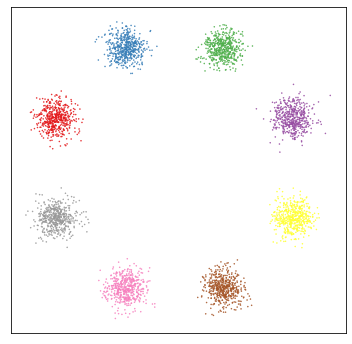

In [31]:
batch_size = 1600
test_split = 2**12

pos, labels = generate(
    labels='all',
    tot_dataset_size=test_split
)
c = np.where(labels[:test_split])[1]
plt.figure(figsize=(6, 6))
plt.scatter(pos[:test_split, 0], pos[:test_split, 1], c=c, cmap='Set1', s=0.25)
plt.xticks([])
plt.yticks([])
plt.show()

In [32]:
pos = pos.to(device)
labels = labels.to(device)

# Training
We now build our conditional INN based on no. of input dimensions `ndim_x`, the dimensions of the condition `ndim_cond`. The INN consists of `no_coupling_blocks` coupling blocks where each got subnets of `nh` hidden neurons and `nl` hidden layers.

In [33]:
ndim_x = 2
ndim_cond = 8
ndim_z = 2

no_coupling_blocks = 2
nh = 512
nl = 1

model = build_model(ndim_x, ndim_cond, no_coupling_blocks, nh, nl)
model = model.to(device)

Next, we define some hyperparameters that guide our optimizer which is used to minimize negative log-likelihood `NLL`.

In [34]:
# Training parameters
n_epochs = 50
n_its_per_epoch = 8

lr = 1e-3

trainable_parameters = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.Adam(trainable_parameters, lr=lr, betas=(0.8, 0.9),
                             eps=1e-6, weight_decay=l2_reg)

Prepare data loaders for training and test data. We can use the training loader to play with the `shuffle` parameter.

In [35]:
batch_size = int(labels.sum(axis=0)[0])
batch_size = 4096

test_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(pos, labels),
    batch_size=batch_size, shuffle=True, drop_last=True)

train_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(pos, labels),
    batch_size=batch_size, shuffle=True, drop_last=True)

The training finally comes in this cell. Here, the model is trained to minimize NLL. 

100%|###########################################| 50/50 [00:07<00:00,  7.11it/s]




Training took 0.12 minutes



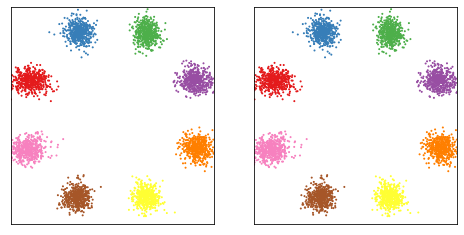

In [37]:
for param in trainable_parameters:
    param.data = 0.05*torch.randn_like(param)
            
model.to(device)

fig, axes = plt.subplots(1, 2, figsize=(8,4))
axes[0].set_xticks([])
axes[0].set_yticks([])
axes[0].set_title('Predicted labels (Forwards Process)')
axes[1].set_xticks([])
axes[1].set_yticks([])
axes[1].set_title('Generated Samples (Backwards Process)')
fig.show()
fig.canvas.draw()

N_samp = 4096

x_samps = torch.cat([x for x,y in test_loader], dim=0)[:N_samp].cpu()
y_samps = torch.cat([y for x,y in test_loader], dim=0)[:N_samp]
c = np.where(y_samps.cpu())[1]
            
try:
    t_start = time()
    for i_epoch in tqdm(range(n_epochs), ascii=True, ncols=80):
        train_NLL(model, trainable_parameters, optimizer, train_loader, i_epoch, n_its_per_epoch)

        # sample posterior distribution provided 
        z = torch.randn(N_samp, ndim_x).cuda()
        rev_x, _ = model(z, y_samps, rev=True)
        rev_x = rev_x.cpu().data.numpy()

        axes[0].clear()
        axes[0].scatter(rev_x[:,0], rev_x[:,1], c=c, cmap='Set1', s=1., vmin=0, vmax=9)
        axes[0].axis('equal')
        axes[0].axis([-3,3,-3,3])
        axes[0].set_xticks([])
        axes[0].set_yticks([])

        axes[1].clear()
        axes[1].scatter(rev_x[:,0], rev_x[:,1], c=c, cmap='Set1', s=1., vmin=0, vmax=9)
        axes[1].axis('equal')
        axes[1].axis([-3,3,-3,3])
        axes[1].set_xticks([])
        axes[1].set_yticks([])

        fig.canvas.draw()


except KeyboardInterrupt:
    pass
finally:
    print(f"\n\nTraining took {(time()-t_start)/60:.2f} minutes\n")